This notebook works with Anaconda 5.1 distribution (Python 3.6). 
Also jieba package required. Use 'pip install jieba3k' to install it. 
Vasilev Sergey +375 29 773-12-72, vasiluev@tut.by

### 1. Import libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from time import time

from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score

E:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import jieba

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

### 2. Load data

In [4]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

In [5]:
data = pd.read_csv('jd_reviews.csv', parse_dates=['created_at'], date_parser=dateparse)

In [6]:
data.head()

,review_id,review,created_at,product_id,product_name,stars
0,68282,NaN,2017-05-22,79877543,大白兔 上海冠生园奶糖散装喜糖结婚庆年货糖果500g 约95个怀旧零食品儿童小吃,NaN
1,52414,就算保质期一个月，还有一个星期过期的巧克力也拿到平台上卖？,2017-01-13,96514296,日本北海道进口royce生巧克力圣诞节情人节礼物巧克力礼盒装 纯黑苦【现货当天发】,1.0
2,40670,太贵！其他的都可以！,2016-09-25,79848693,【哈肉联】风干香肠 单根50g 瘦肉块有嚼劲 哈尔滨特产齐名红肠 *24根 [整箱],4.0
3,12727,很理想 满意,2016-12-25,79295853,天之缘 一次性双喜红地毯结婚地毯开业庆典门垫地毯婚庆红地毯 百年好合双喜红地毯（10米价格）,5.0
4,9456,满满的狗粮！谁要吃,2017-06-04,74142329,比瑞吉天然粮 狗粮 比熊室内成犬粮2kg,5.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
review_id       100000 non-null int64
review          95017 non-null object
created_at      100000 non-null datetime64[ns]
product_id      100000 non-null int64
product_name    100000 non-null object
stars           89985 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 4.6+ MB


### 3. Data analysis

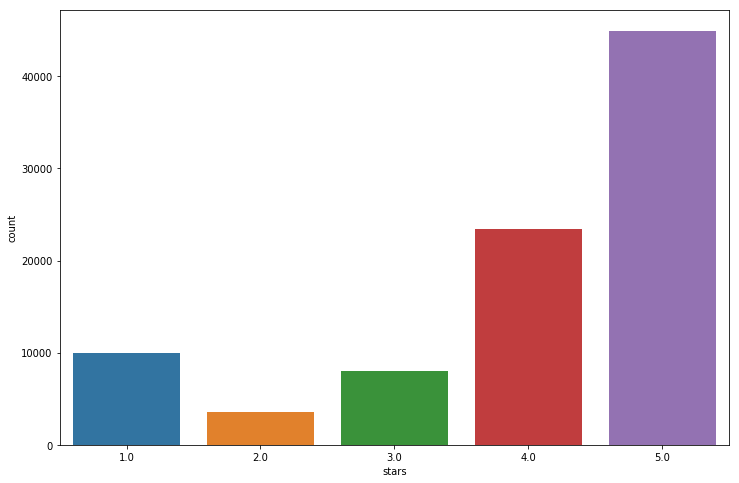

In [10]:
#stars distribution
sns.countplot(x='stars', data=data)

The most popular rating in dataset - 5

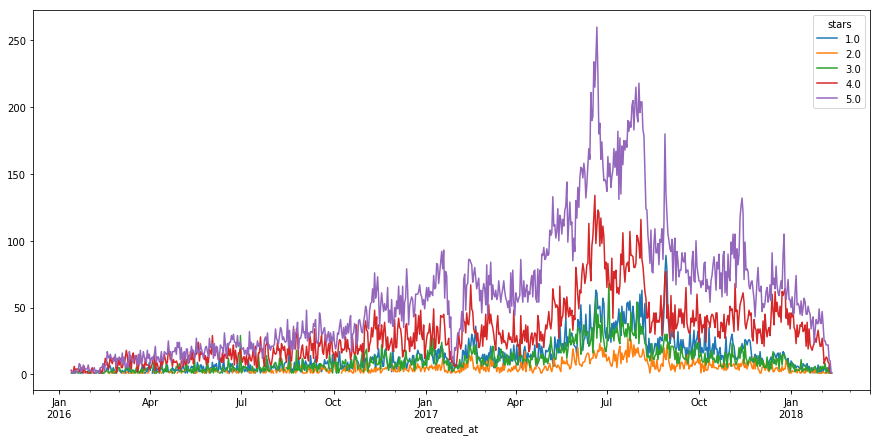

In [11]:
#plot number of reviews by stars by day
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['created_at','stars']).count()['review_id'].unstack().plot(ax=ax)

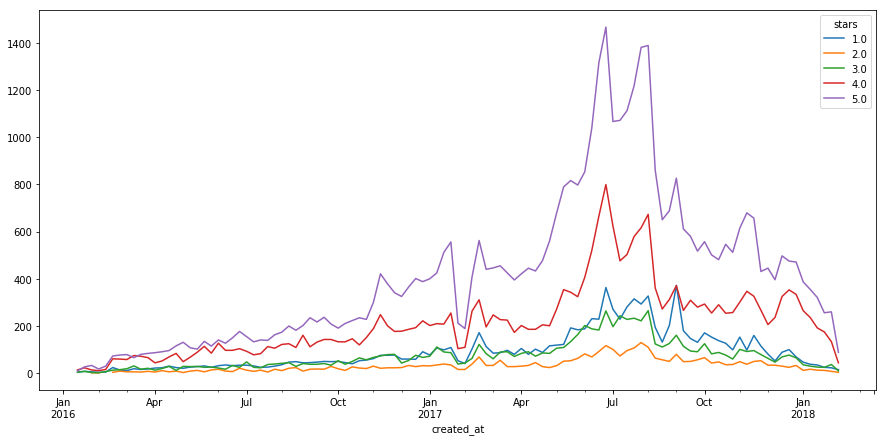

In [10]:
#plot number of reviews by stars by weeks
fig2, ax2 = plt.subplots(figsize=(15,7))
data.groupby([pd.Grouper(key='created_at', freq='1W'),'stars']).count()['review_id'].unstack().plot(ax=ax2)

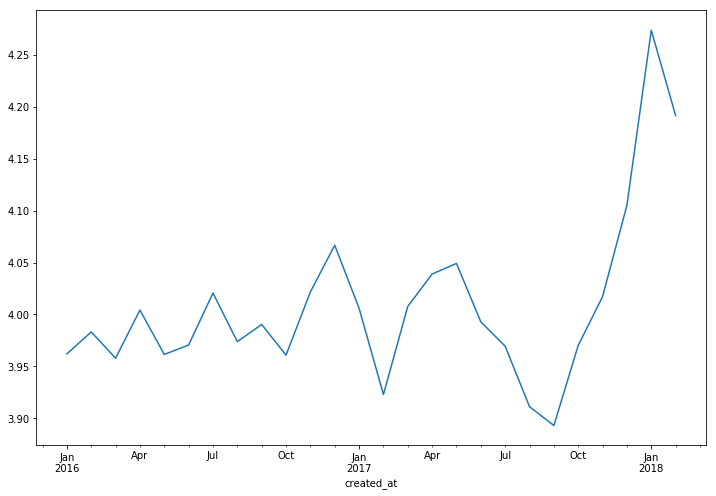

In [12]:
#average rating by month
data.groupby(pd.Grouper(key='created_at', freq='1M'))['stars'].mean().plot()

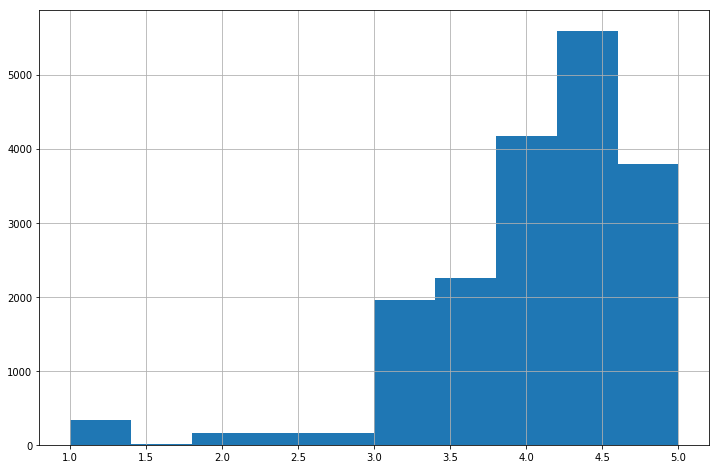

In [13]:
#destribution products by ratings
data.groupby(['product_id'])['stars'].mean().hist()

The most popular average rating by product 4 - 4.5

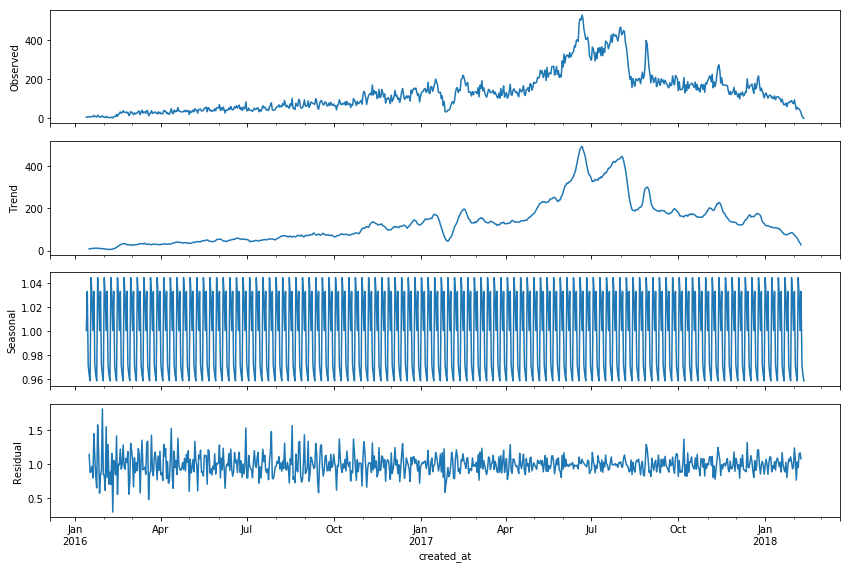

In [41]:
# time series decomposition by 
from statsmodels.tsa.seasonal import seasonal_decompose
series = data.groupby(['created_at']).count()['review_id']
result = seasonal_decompose(series, model='additive')
result.plot()
plt.show()

### 3. Data preprocessing for machine learning

In [15]:
#remove reviews without stars
data_with_stars = data[np.isfinite(data['stars'])]

In [16]:
data_with_stars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89985 entries, 1 to 99999
Data columns (total 6 columns):
review_id       89985 non-null int64
review          89983 non-null object
created_at      89985 non-null datetime64[ns]
product_id      89985 non-null int64
product_name    89985 non-null object
stars           89985 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 4.8+ MB


In [17]:
reviews = pd.DataFrame(data_with_stars['review'])
labels = data_with_stars['stars']

In [18]:
#remove punctuations
reviews["review"] = reviews["review"].str.replace('[^\w\s]','')

In [19]:
for i in reviews.index:
    if type(reviews["review"][i]) == str:
        reviews["review"][i] = ' '.join(list(jieba.cut(reviews["review"][i])))
    else:
        reviews["review"][i] = str(reviews["review"][i])

Building prefix dict from E:\Anaconda3\lib\site-packages\jieba\dict.txt ...
Loading model from cache C:\Users\vasil\AppData\Local\Temp\jieba.cache
Loading model cost 1.7679121494293213 seconds.
Prefix dict has been built succesfully.


In [20]:
reviews_for_vector = reviews["review"].values

### 3. Word to vector

In [21]:
#define stop words list
stop_words = pd.read_table('stopwords_zh.txt')
stop_words = stop_words['的'].tolist()

**Convert words to vectors**

In [22]:
# TfIdf vectorization
vectorizer = TfidfVectorizer(max_df=0.5, analyzer = 'word', min_df=2, stop_words=stop_words)

In [23]:
X = vectorizer.fit_transform(reviews_for_vector.ravel())
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 89985, n_features: 22507


**Performing dimensionality reduction**

In [24]:
# Performing dimensionality reduction using LSA 
print("Performing dimensionality reduction using LSA")
t0 = time()
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD(200)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_dim_red = lsa.fit_transform(X)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Performing dimensionality reduction using LSA
done in 23.565564s
Explained variance of the SVD step: 46%


We make a dimensionality reduction for speed up ML algorithm. Without dimensionality reduction we get an accuracy 0.65 (Random Forest). With DR we get an accuracy 0.639, but algorithm works faster

### 4. Classification

In [25]:
#train - test split
X_train, X_test, y_train, y_test = train_test_split(X_dim_red, labels, test_size=0.20, random_state=52)

In [26]:
# train the classifier - RandomForest classifier
clf = RandomForestClassifier(n_estimators = 100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [27]:
#prediction for test data 
y_pred = clf.predict(X_test)
print("Test data accuracy:" + str(accuracy_score(y_test, y_pred)))

Test data accuracy:0.6397177307329


In [28]:
clf_lg = LogisticRegression(random_state=42)
clf_lg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
#prediction for test data 
y_pred = clf_lg.predict(X_test)
print("Test data accuracy:" + str(accuracy_score(y_test, y_pred)))

Test data accuracy:0.5896538311940879


In [30]:
# train model on all training data
clf_all = RandomForestClassifier(n_estimators = 100, random_state=42, n_jobs=-1)
clf_all.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### 5. Make a predictions

In [40]:
# load new data for prediction
file = 'new_reviews.csv' # path and filename of new data

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
new_data = pd.read_csv(file, parse_dates=['created_at'], date_parser=dateparse)
new_reviews = pd.DataFrame(new_data['review'])
new_reviews["review"] = new_reviews["review"].str.replace('[^\w\s]','')

for i in new_reviews.index:
    if type(new_reviews["review"][i]) == str:
        new_reviews["review"][i] = ' '.join(list(jieba.cut(new_reviews["review"][i])))
    else:
        new_reviews["review"][i] = str(new_reviews["review"][i])

reviews_for_vector_new = new_reviews["review"].values

X_new = vectorizer.transform(reviews_for_vector_new.ravel())
X_dim_red_new = lsa.transform(X_new) 
prediction = clf_all.predict(X_dim_red_new)
result = pd.DataFrame(new_data['review_id'])
result['star_prediction'] = prediction
result.to_csv('result.csv', index=False)